<a href="https://colab.research.google.com/github/lukemc125/Stock-Market/blob/main/StockMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Project - Stock Market Analysis

In this notebook, we'll discover and explore some stock data from the US stock market (Apple, Microsoft, Google, and Sony). We'll input the data from yfinance and perform some analyses as well as predict future stock prices with a LSTM.

We'll be answering the following questions along the way:

- Daily return of the stock on average?
- Moving average of the various stocks?
- Correlation between different stocks
- Risk for investing in each stock
- Build LSTM Prediction Model

In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
%matplotlib inline
sns.set_style('whitegrid')

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()


In [5]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'SONY', 'MSFT']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)


company_list = [AAPL, GOOG, SONY, MSFT]
company_name = ["APPLE", "GOOGLE", "SONY", "MICROSOFT"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.tail of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-07-25  154.009995  155.039993  152.279999  152.949997  152.042130   
2022-07-26  152.259995  153.089996  150.800003  151.600006  150.700134   
2022-07-27  152.580002  157.330002  152.160004  156.789993  155.859314   
2022-07-28  156.979996  157.639999  154.410004  157.350006  156.416016   
2022-07-29  161.240005  163.630005  159.500000  162.509995  161.545364   
...                ...         ...         ...         ...         ...   
2023-07-18  345.829987  366.779999  342.170013  359.489990  359.489990   
2023-07-19  361.750000  362.459991  352.440002  355.079987  355.079987   
2023-07-20  353.570007  357.970001  345.369995  346.869995  346.869995   
2023-07-21  349.149994  350.299988  339.829987  343.769989  343.769989   
2023-07-24  345.850006  346.920013  342.320007  344.220001  344.220001   

       

## Descriptive Statistics about the Data

In [6]:
# Summary Stats
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,157.790359,159.616255,156.232151,158.018280,157.642236,7.093902e+07
std,16.760102,16.571702,17.092708,16.858201,16.989125,2.314278e+07
min,126.010002,127.769997,124.169998,125.019997,124.656982,2.702114e+07
25%,145.815002,147.340004,144.014999,145.919998,145.470383,5.412610e+07
50%,154.009995,156.669998,152.880005,154.529999,154.051376,6.782940e+07
75%,169.755005,170.684998,168.035004,169.415001,168.862328,8.142645e+07
max,195.089996,198.229996,192.830002,195.100006,195.100006,1.647624e+08


In [7]:
# General info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-07-25 to 2023-07-24
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          251 non-null    float64
 1   High          251 non-null    float64
 2   Low           251 non-null    float64
 3   Close         251 non-null    float64
 4   Adj Close     251 non-null    float64
 5   Volume        251 non-null    int64  
 6   company_name  251 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.7+ KB


## Closing Price

The closing price is the last price at which the stock is traded during the regular trading day.

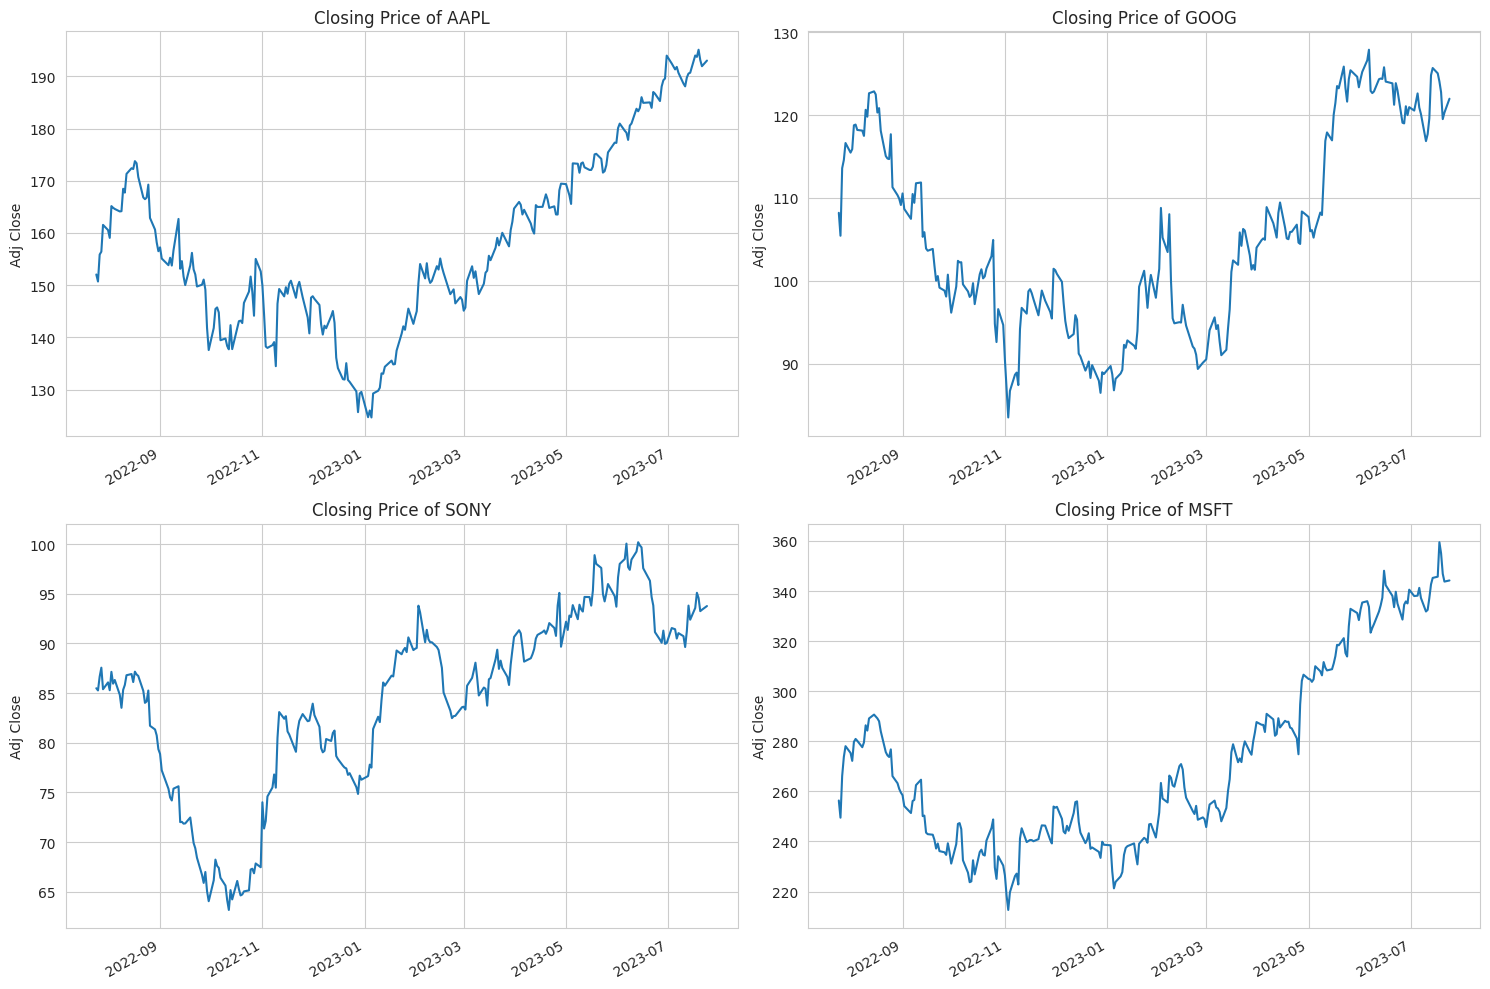

In [10]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

## Volume of Sales
Stock trading volume refers to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

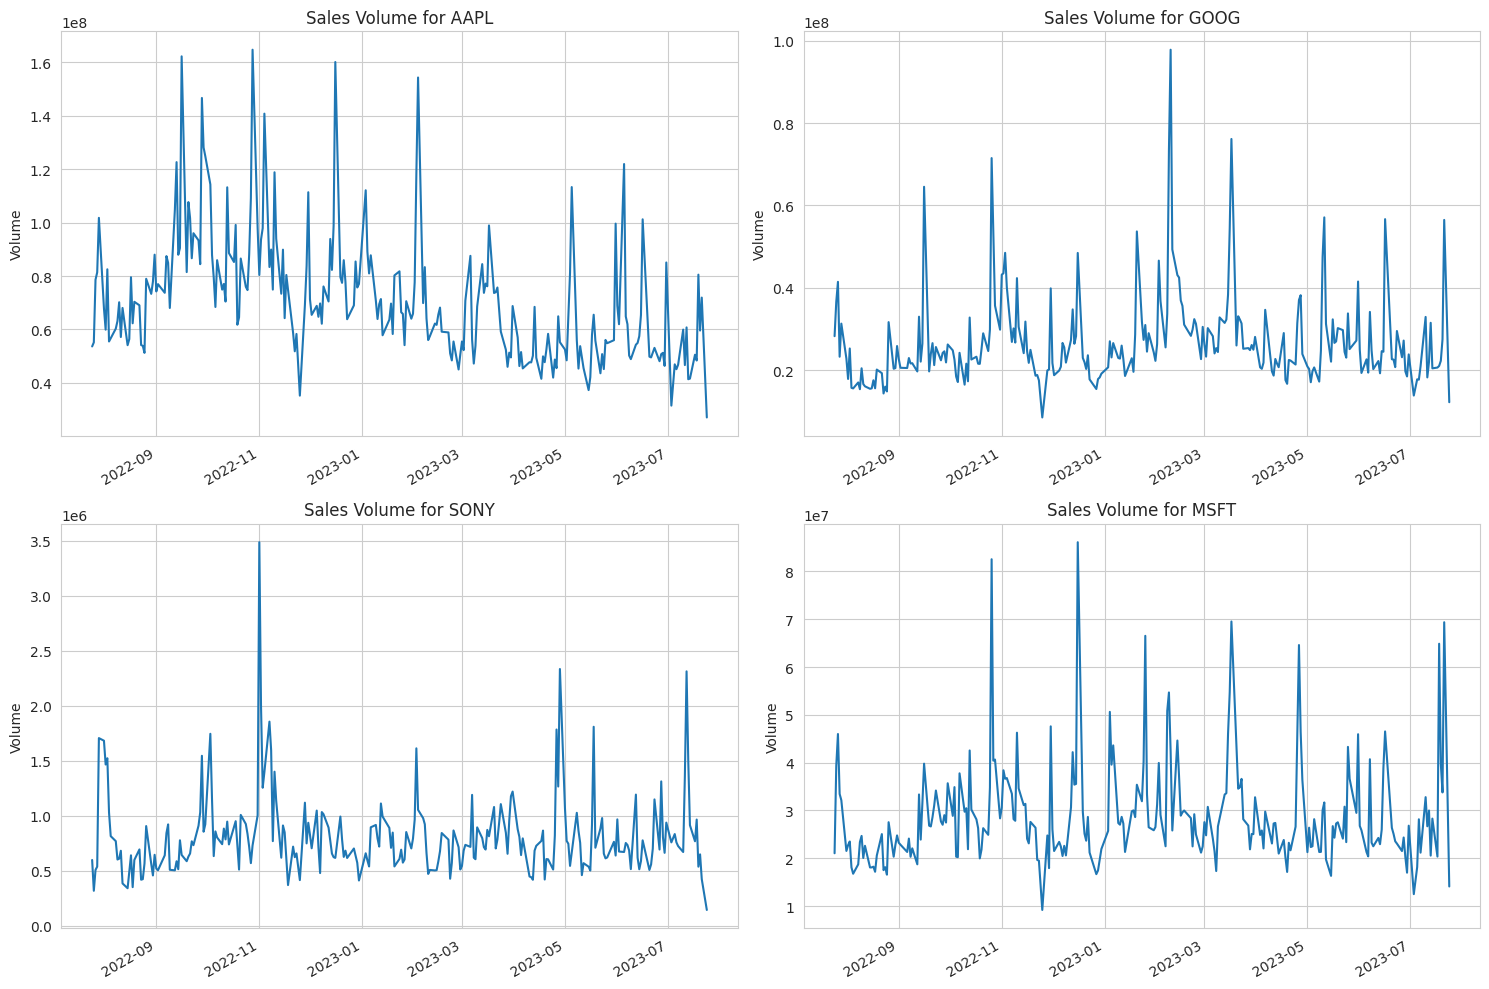

In [11]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")

plt.tight_layout()

# Moving average

Now that we've seen the visualizations for the closing price and the volume traded each day, let's go ahead and caculate the moving average for the stock.The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

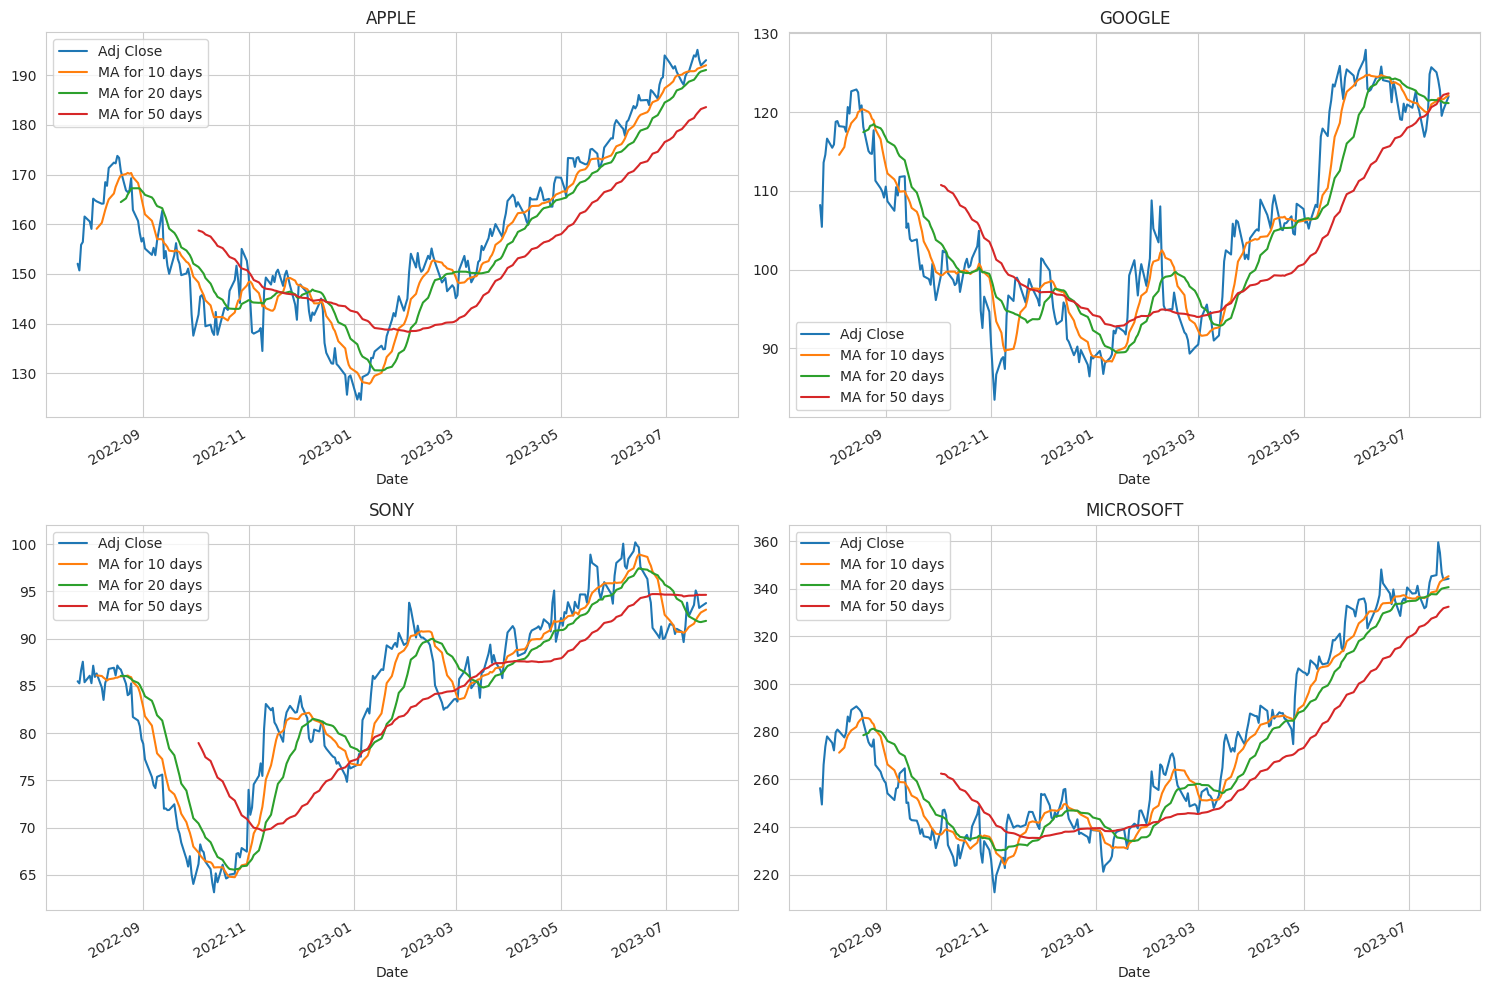

In [12]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

SONY[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('SONY')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('MICROSOFT')

fig.tight_layout()

## Correlation Between Stocks

In [13]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%***********************]  4 of 4 completed


,AAPL,GOOG,MSFT,SONY
Date,,,,
2022-07-25,NaN,NaN,NaN,NaN
2022-07-26,-0.008826,-0.025598,-0.026774,-0.002573
2022-07-27,0.034235,0.077390,0.066852,0.016301
2022-07-28,0.003572,0.008715,0.028541,0.010385
2022-07-29,0.032793,0.017890,0.015665,-0.024783


Now we can compare the daily percentage return of two stocks to check how correlated.

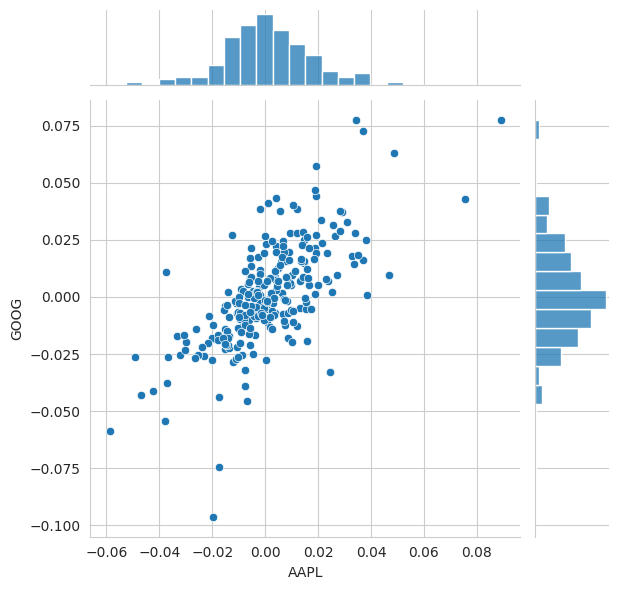

In [16]:
# We'll use joinplot to compare the daily returns of Google and SONY
sns.jointplot(x='AAPL', y='GOOG', data=tech_rets, kind='scatter')

So now we can see that if two stocks are perfectly (and positivley) correlated with each other a linear relationship bewteen its daily return values should occur.

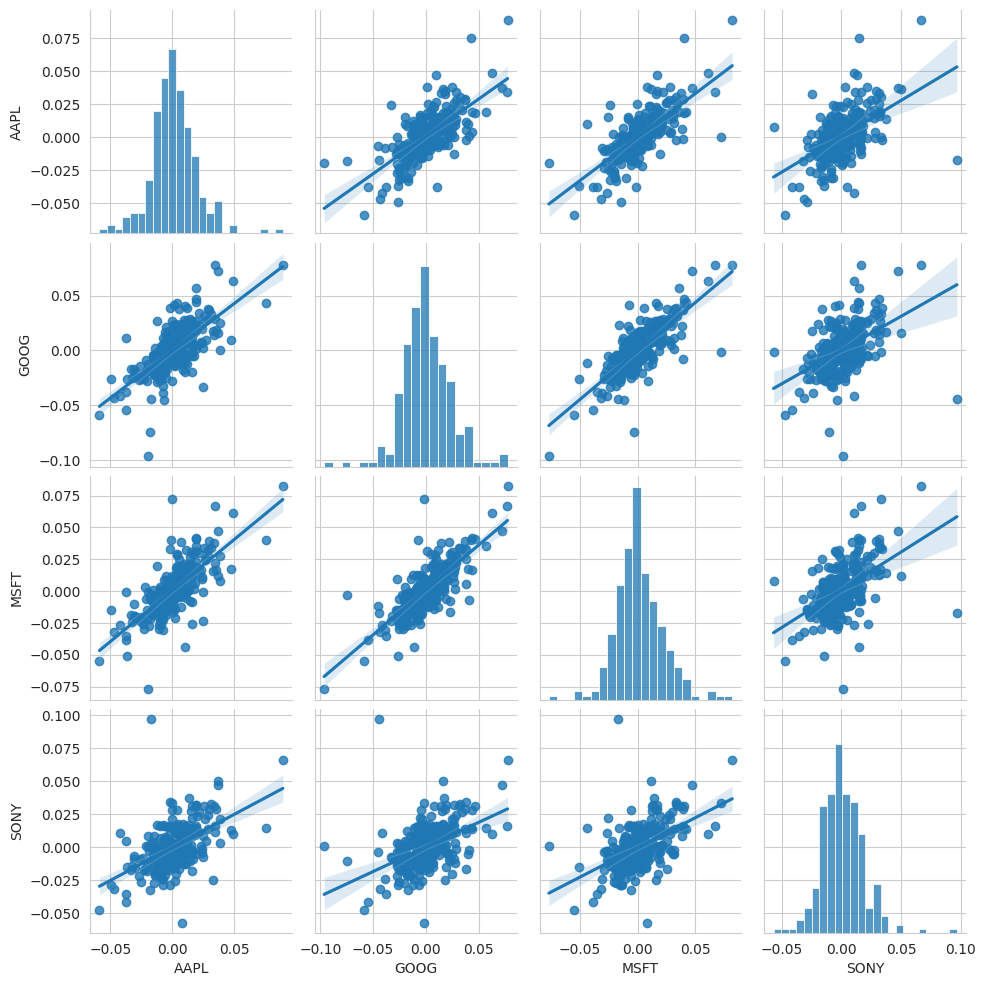

In [29]:
sns.pairplot(tech_rets, kind='reg')

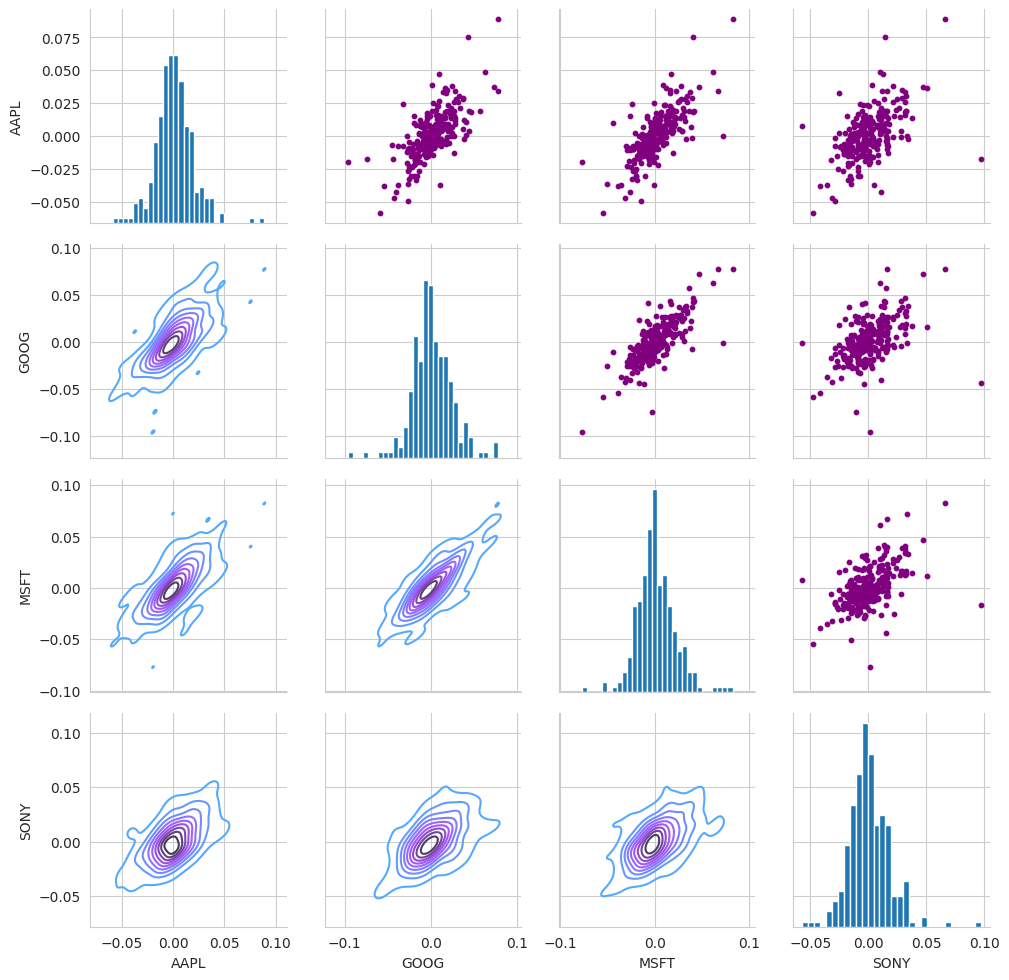

In [25]:
return_fig = sns.PairGrid(tech_rets.dropna())

# Map Upper
return_fig.map_upper(plt.scatter, color='purple', s=10)

# Lower triangle in the figure, inclufing the plot type (kde)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

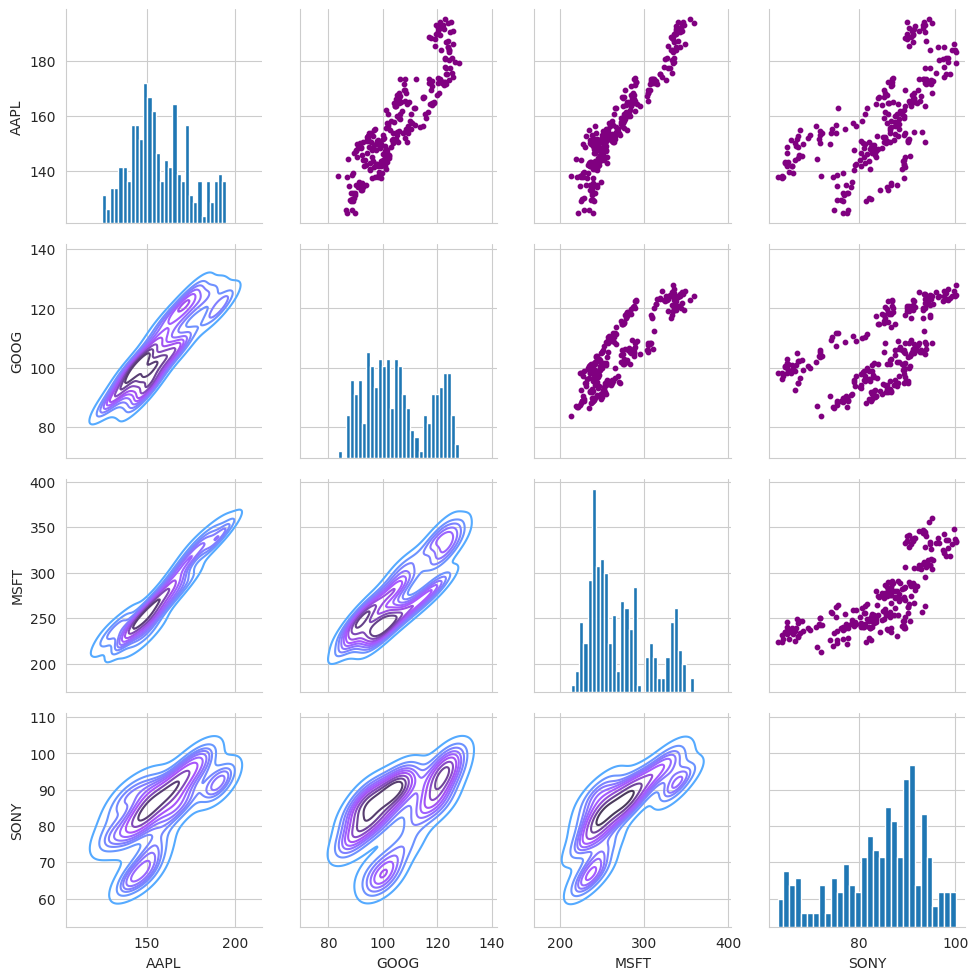

In [30]:
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter, color='purple', s=10)

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

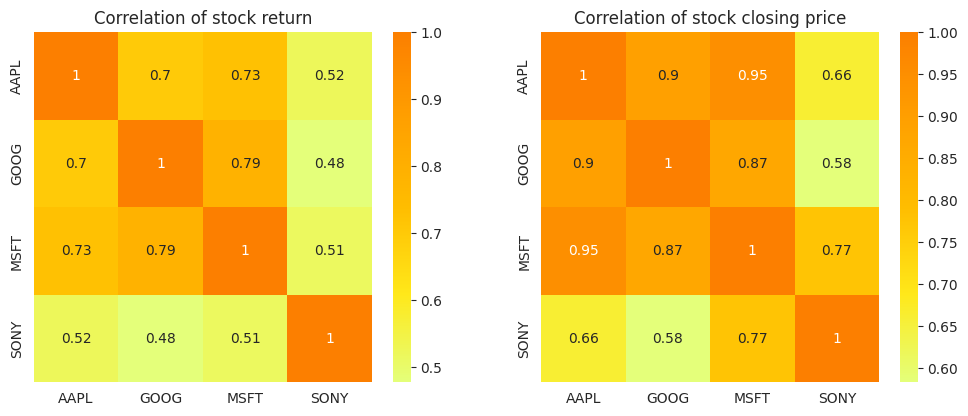

In [34]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='Wistia')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='Wistia')
plt.title('Correlation of stock closing price')

Just like we saw in our PairPlot we see here numerically and visually that Google and Microsoft had the strongest correlation of daily stock return. And there's a very strong Closing price correlation between Apple, Microsoft and Google

## Simple Risk Overview

There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

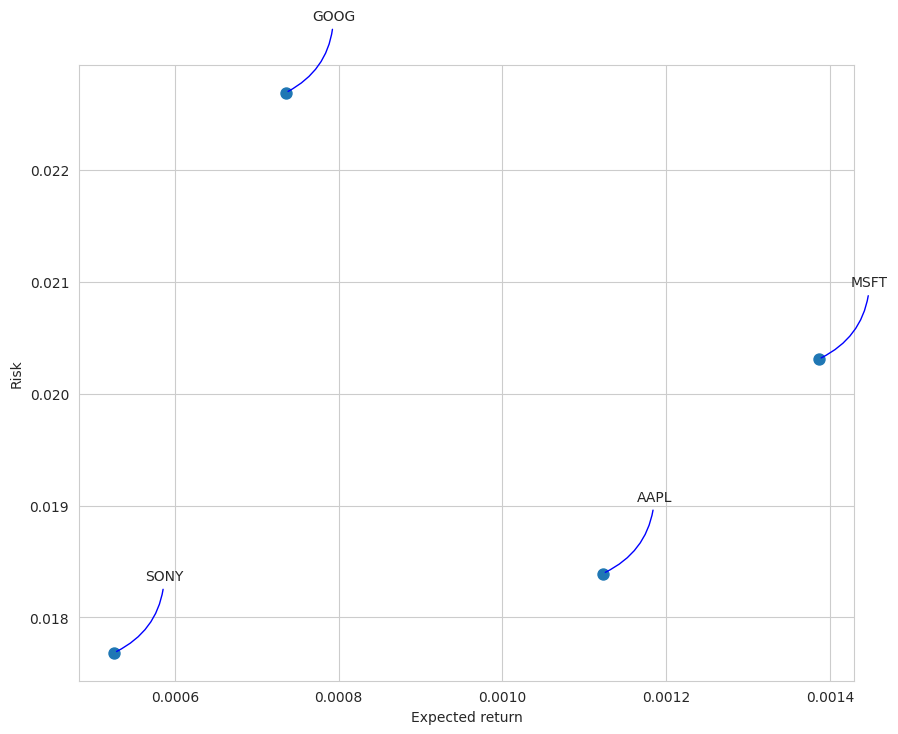

In [36]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

# Predicting the closing price stock price of APPLE

In [39]:
# Get the stock quote
df = pdr.get_data_yahoo('MSFT', start='2012-01-01', end=datetime.now())
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,26.549999,26.959999,26.389999,26.770000,21.366358,64731500
2012-01-04,26.820000,27.469999,26.780001,27.400000,21.869186,80516100
2012-01-05,27.379999,27.730000,27.290001,27.680000,22.092676,56081400
2012-01-06,27.530001,28.190001,27.530001,28.110001,22.435875,99455500
2012-01-09,28.049999,28.100000,27.719999,27.740000,22.140560,59706800
...,...,...,...,...,...,...
2023-07-18,345.829987,366.779999,342.170013,359.489990,359.489990,64872700
2023-07-19,361.750000,362.459991,352.440002,355.079987,355.079987,39732900
2023-07-20,353.570007,357.970001,345.369995,346.869995,346.869995,33778400


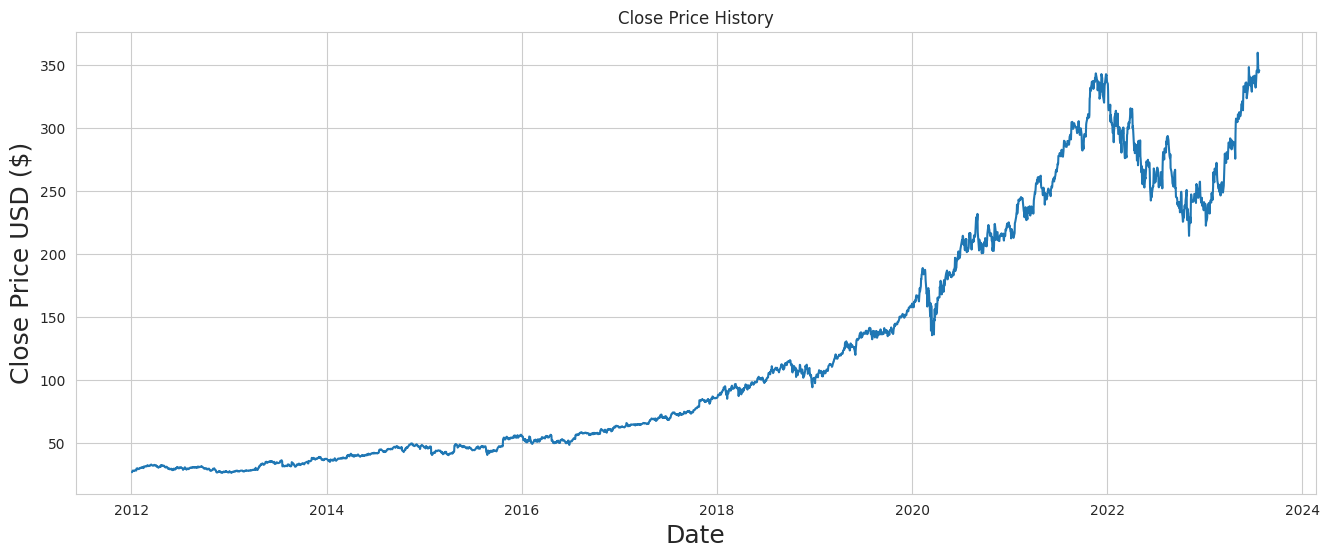

In [40]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [44]:
# Training the data

data = df.filter(['Close'])

dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .95 ))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00120077, 0.00309198, 0.00393252, 0.00522334, 0.00411263,
       0.00441282, 0.00405259, 0.00489313, 0.00564361, 0.00567363,
       0.00558357, 0.00525336, 0.01002641, 0.01008645, 0.0089157 ,
       0.00957612, 0.00939601, 0.00858549, 0.00972622, 0.00948607,
       0.01056676, 0.01074688, 0.01161743, 0.01149736, 0.01194765,
       0.01287824, 0.01320845, 0.01239793, 0.01263809, 0.01164745,
       0.01104707, 0.01476945, 0.01464937, 0.01521974, 0.01470941,
       0.01500961, 0.01533981, 0.01494957, 0.01651057, 0.01612031,
       0.01777137, 0.01714097, 0.01630043, 0.01557997, 0.01642051,
       0.01693083, 0.01687079, 0.01702089, 0.0189121 , 0.0192123 ,
       0.01945244, 0.01870196, 0.0175012 , 0.01687079, 0.01663064,
       0.01690081, 0.01693083, 0.01867195, 0.01846182, 0.01747118])]
[0.017261041893918916]

[array([0.00120077, 0.00309198, 0.00393252, 0.00522334, 0.00411263,
       0.00441282, 0.00405259, 0.00489313, 0.00564361, 0.00567363,
       0.00558357, 0.00525336, 0.0

In [46]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2702/2702 [==============================] - 115s 41ms/step - loss: 0.0013


In [60]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 0s 54ms/step


8.967206085016315

<ipython-input-58-c68708990f62>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['Predictions'] = predictions


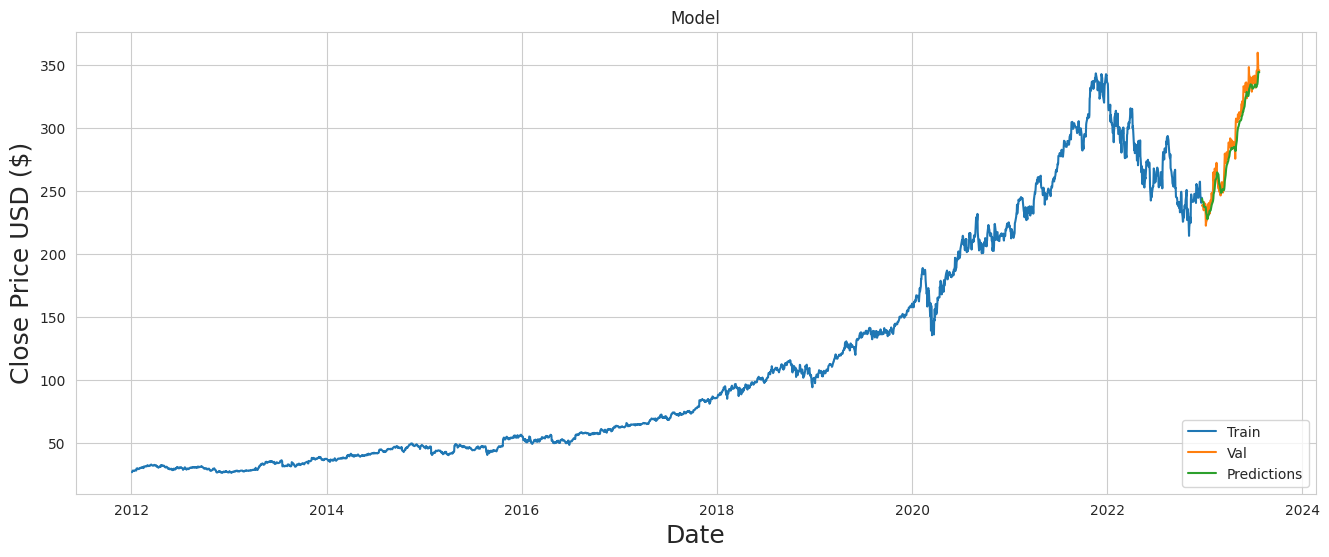

In [58]:
# Plot the data
train = data[:training_data_len]
preds = data[training_data_len:]
preds['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(preds[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [61]:
# Close vs Predicted Prices
preds

,Close,Predictions
Date,,
2022-12-22,238.190002,243.675964
2022-12-23,238.729996,242.052841
2022-12-27,236.960007,240.584000
2022-12-28,234.529999,239.138489
2022-12-29,241.009995,237.567719
...,...,...
2023-07-18,359.489990,336.386963
2023-07-19,355.079987,340.015839
2023-07-20,346.869995,343.120087
